Import the neccessary libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


Data Loading

In [15]:
try:
    df = pd.read_csv("coin_Dogecoin.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'coin_Dogecoin.csv' was not not found")
df

Data loaded successfully!


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Dogecoin,DOGE,2013-12-16 23:59:59,0.000866,0.000150,0.000299,0.000205,0.000000e+00,1.509085e+06
1,2,Dogecoin,DOGE,2013-12-17 23:59:59,0.000289,0.000116,0.000207,0.000269,0.000000e+00,2.169688e+06
2,3,Dogecoin,DOGE,2013-12-18 23:59:59,0.000362,0.000205,0.000267,0.000362,0.000000e+00,3.188943e+06
3,4,Dogecoin,DOGE,2013-12-19 23:59:59,0.001520,0.000328,0.000395,0.001162,0.000000e+00,1.115034e+07
4,5,Dogecoin,DOGE,2013-12-20 23:59:59,0.001143,0.000662,0.001143,0.000704,0.000000e+00,7.284337e+06
...,...,...,...,...,...,...,...,...,...,...
2755,2756,Dogecoin,DOGE,2021-07-02 23:59:59,0.247997,0.238848,0.243982,0.245264,1.321471e+09,3.194925e+10
2756,2757,Dogecoin,DOGE,2021-07-03 23:59:59,0.250214,0.242454,0.245106,0.246411,9.170158e+08,3.210491e+10
2757,2758,Dogecoin,DOGE,2021-07-04 23:59:59,0.252567,0.243425,0.246425,0.246483,9.735115e+08,3.211767e+10
2758,2759,Dogecoin,DOGE,2021-07-05 23:59:59,0.246419,0.227838,0.246419,0.231614,1.267949e+09,3.018344e+10


Data Preprocessing

In [16]:
# Rename the columns for clarity and consistency
df.rename(columns={
    "SNo":"serial_number",
    "Name":"name",
    "Symbol":"symbol",
    "Date":"date",
    "High":"high",
    "Low":"low",
    "Open":"open",
    "Close":"close",
    "Volume":"volume",
    "Marketcap":"marketcap"
},inplace=True)


In [17]:
# Convert the "date" column to datetime object
df["date"] = pd.to_datetime(df["date"])

In [18]:
# Sort the data by date to maintain time series order
df = df.sort_values(by="date")

In [19]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
serial_number    0
name             0
symbol           0
date             0
high             0
low              0
open             0
close            0
volume           0
marketcap        0
dtype: int64


In [20]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


In [21]:
# Calculate "days-_since_start" as simple temporal feature
# This feature helps the model capture time-based trends in the price
df["days_since_start"] = (df["date"] - df["date"].min()).dt.days

In [22]:
print(f"Data shape after cleaning: {df.shape}")

Data shape after cleaning: (2760, 11)


In [23]:
print("Columns available for modeling:",df.columns.tolist())

Columns available for modeling: ['serial_number', 'name', 'symbol', 'date', 'high', 'low', 'open', 'close', 'volume', 'marketcap', 'days_since_start']


Visualization before training

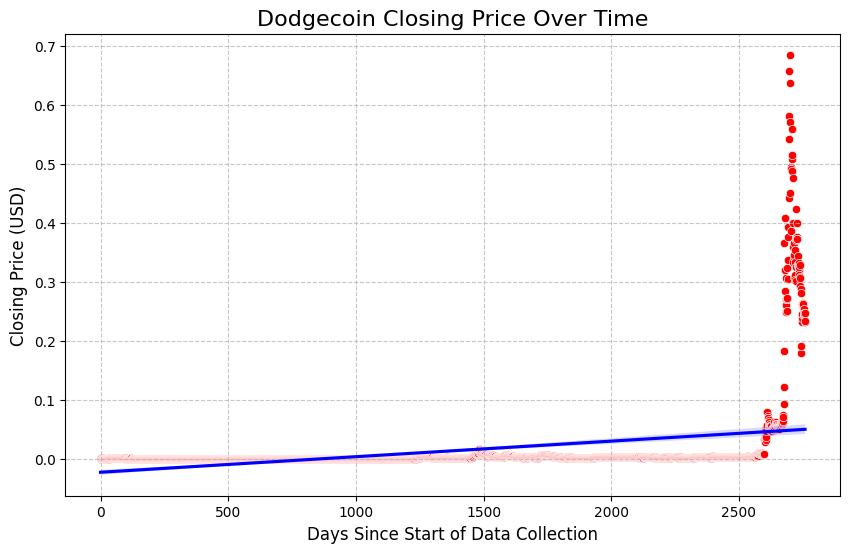

In [24]:
plt.figure(figsize=(10,6))
# Create a scatter plot to show how the closing price (target) has changed over time
sns.scatterplot(x="days_since_start", y="close", data=df,color="red")

# Add trend line for better visual understanding of the overall price movement
sns.regplot(x="days_since_start",y="close",data=df,scatter=False,color="blue")

plt.title("Dodgecoin Closing Price Over Time", fontsize=16)
plt.xlabel("Days Since Start of Data Collection", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True,linestyle="--",alpha=0.7)
plt.show()

Feature Engineering

In [25]:
# Select the features (X) and target variable (y)
# We'll use the "high","low","open" and "volume" to predict the "close" price

features = ["high","low","open","volume"]
X = df[features]
y = df["close"]

Data Splitting and Scaling

In [26]:
# Split the data into training (80%) and testing (20%) sets
# random_state ensures reproducibilty
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Initialize the StandardScaler for feature scaling
# Scaling is crucial for regularized models like Lasso and Ridge Regression
scaler = StandardScaler()

# Fit the scaler only on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 2208 samples
Testing set size: 552 samples


Model Training and Evaluation

In [27]:
#  Dictionary to hold all models and a list to store results
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0,random_state=42),
    "Lasso Regression": Lasso(alpha=0.01,random_state=42,max_iter=2000),
    "ElasticNet": ElasticNet(alpha=0.01,l1_ratio=0.5,random_state=42,max_iter=2000)
}
results = []

# Iterate through each model
for name, model in models.items():
    # Train the model using the scaled training data
    model.fit(X_train_scaled,y_train)

    # Make predictions on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate performance using the standard regression metrics
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    # Store the results for comparison
    results.append({
        "Model":name,
        "R-squared":r2,
        "Mean Squared Error":mse,
        "Mean Absolute Error": mae,
        "Predictions":y_pred
    })

    # Print the summary of the model's performance
    print(f"{name} Results:")
    print(f"R-squared: {r2:.4f}")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")

    results_df = pd.DataFrame(results)

    # Identify the best model on the R-squared (highest R2 indicated best fit)
    best_model_name = results_df.loc[results_df["R-squared"].idxmax()]["Model"]
    best_model = models[best_model_name]
    print(f"Best Performing Model: {best_model_name}")

Linear Regression Results:
R-squared: 0.9948
MSE: 0.000018
MAE: 0.001459
Best Performing Model: Linear Regression
Ridge Regression Results:
R-squared: 0.9952
MSE: 0.000017
MAE: 0.001458
Best Performing Model: Ridge Regression
Lasso Regression Results:
R-squared: 0.9856
MSE: 0.000051
MAE: 0.003433
Best Performing Model: Ridge Regression
ElasticNet Results:
R-squared: 0.9955
MSE: 0.000016
MAE: 0.002001
Best Performing Model: ElasticNet


Visualization after training

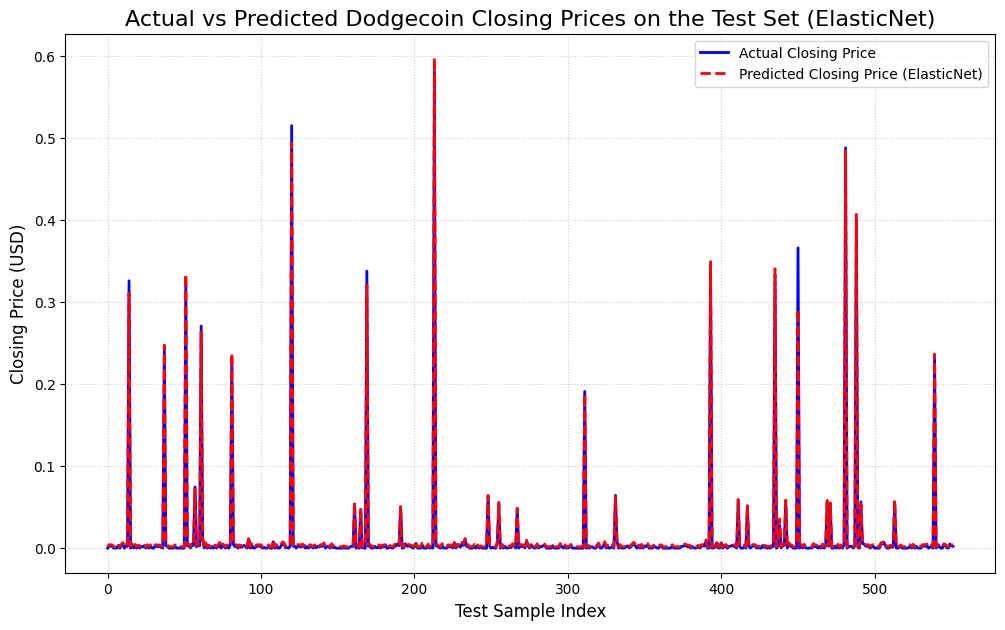

In [28]:
# Get the row of the best performing model
best_model_row = results_df.loc[results_df["R-squared"].idxmax()]
best_predictions = best_model_row["Predictions"]
best_model_name = best_model_row["Model"]

plt.figure(figsize=(12,7))

# Plot the actual closing price from the test set
plt.plot(y_test.values,label="Actual Closing Price",color="blue",linewidth=2)

# Plot the predicted closing prices from the best model
plt.plot(best_predictions,label=f"Predicted Closing Price ({best_model_name})",color="red",linestyle="--",linewidth=2)

plt.title(f"Actual vs Predicted Dodgecoin Closing Prices on the Test Set ({best_model_name})",fontsize=16)
plt.xlabel("Test Sample Index",fontsize=12)
plt.ylabel("Closing Price (USD)",fontsize=12)
plt.legend()
plt.grid(True,linestyle=":",alpha=0.6)
plt.show()